In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Required Packages**

In [2]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not cur

#**Import All the Required Libraries**

In [3]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

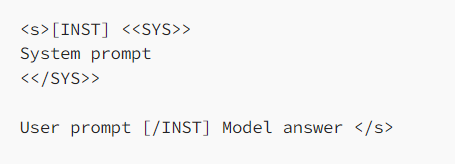

- Orignal Dataset: https://huggingface.co/datasets/qiaojin/PubMedQA

- Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/viniljpk/pubmedQA_v1?row=4

To know how this dataset was created, you can check this notebook.  

https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [4]:
# The model that you want to train from the Hugging Face hub
model_name = "distilbert/distilgpt2"

# The instruction dataset to use
dataset_name = "viniljpk/pubmedQA_v1"

# Fine-tuned model name
new_model = "distilbert_distilgpt2-finetune_vini"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "/content/drive/MyDrive/Colab Notebooks/distilbert/finetuned"

# Number of training epochs
num_train_epochs = 3

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the distilbert_distilgpt2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [8]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=10,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilbert/distilgpt2 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Train model
trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,4.549100
50,4.733900
75,4.178600
100,4.081100
125,3.919600
150,3.657600
175,3.666200
200,3.373200
225,3.563800
250,3.422400


TrainOutput(global_step=2500, training_loss=3.391350570678711, metrics={'train_runtime': 196.6818, 'train_samples_per_second': 50.844, 'train_steps_per_second': 12.711, 'total_flos': 111166955716608.0, 'train_loss': 3.391350570678711, 'epoch': 10.0})

In [10]:
# Save trained model
trainer.model.save_pretrained(new_model)

##**Check the plots on tensorboard, as follows**

In [3]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

###**Use the text generation pipeline to ask questions |  Note that I’m formatting the input to match gpt2 prompt template.**

In [12]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Do mitochondria play a role in remodelling lace plant leaves during programmed cell death??"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=Tr

<s>[INST] Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?? [/INST] Lig of the ossified ossified and stimulated fibroblast cell migration during this time of the ossified and induced fibrocarticular tissue migration. Lig of the ossified and stimulated fibrocarticular tissue migration may provide clues to our involvement with fibromal and mitochondrial cystic fibrosis. </s> </s> <s> Spreading the fibreg-positive nucleus has an important role in the ossified ossified ossified ossified ossified ossified. </s> Least-associated fibroblast cells might be a more important role when stimulation occurs. </s> <s> Least-associated fibroblast cells can play a role in the regulation of the ossified ossified ossified ossified ossified ossified ossified oss


In [13]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

0

You can train a Llama 2 model on the entire dataset using [mlabonne/guanaco-llama2](https://huggingface.co/datasets/mlabonne/guanaco-llama2)

#**Store New Model**

How can we store our new  model now? We need to merge the weights from LoRA with the base model. we need to reload the base model in FP16 precision and use the peft library to merge everything.

In [14]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora.py:299: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:556: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions th

#**Push Model to Hugging Face Hub**

Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.

In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [16]:
!huggingface-cli login

model.push_to_hub("distilgpt2_pmmed_finetuned_vinil", check_pr=True)

tokenizer.push_to_hub("distilgpt2_pmmed_finetuned_vinil",check_pr=True)



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

pytorch_model.bin:   0%|          | 0.00/164M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/viniljpk/Llama-2-7b-chat-finetune_vinil/commit/9e1c093268a25acc7c7910ca9cb4c563ca8db155', commit_message='Upload tokenizer', commit_description='', oid='9e1c093268a25acc7c7910ca9cb4c563ca8db155', pr_url=None, pr_revision=None, pr_num=None)

You can now use this model for inference by loading it like any other Llama 2 model from the Hub.

In [18]:
from transformers import pipeline

# Run text generation pipeline with our next model
prompt = "Do mitochondria play a role in remodelling lace plant leaves during programmed cell death??"
pipe = pipeline(task="text-generation", model="viniljpk/distilgpt2_pmmed_finetuned_vinil", max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/164M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

<s>[INST] Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?? [/INST] This hypothesis is supported. Based on the results of this study, mitochondria play an important role within the growing grassland as well as host plants. The results are consistent with these findings. </s> <s>Covas-induced mitochondrial regeneration in the human skin after programmed cell death or at a postmortem examination suggest that normalization of the structure of the mitochondrial protein kinase enzyme might be necessary if it is to promote healthy leaf growth. </s> </s> Our results indicate that this effect may be mediated by mitochondrial differentiation pathways in response to programmed cell death. </s> </s> </s> <s>Olivas and mitochondrial DNA in both patients and the environment may influence the repair of inflammatory lesions and restore healthy plant growth. </s> <s>In addition to the association with apoptosis, apoptosis may be a potential
